In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
#!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

C:\Users\TnAky\AppData\Local\Temp\ipykernel_22128\2037890326.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


In [4]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


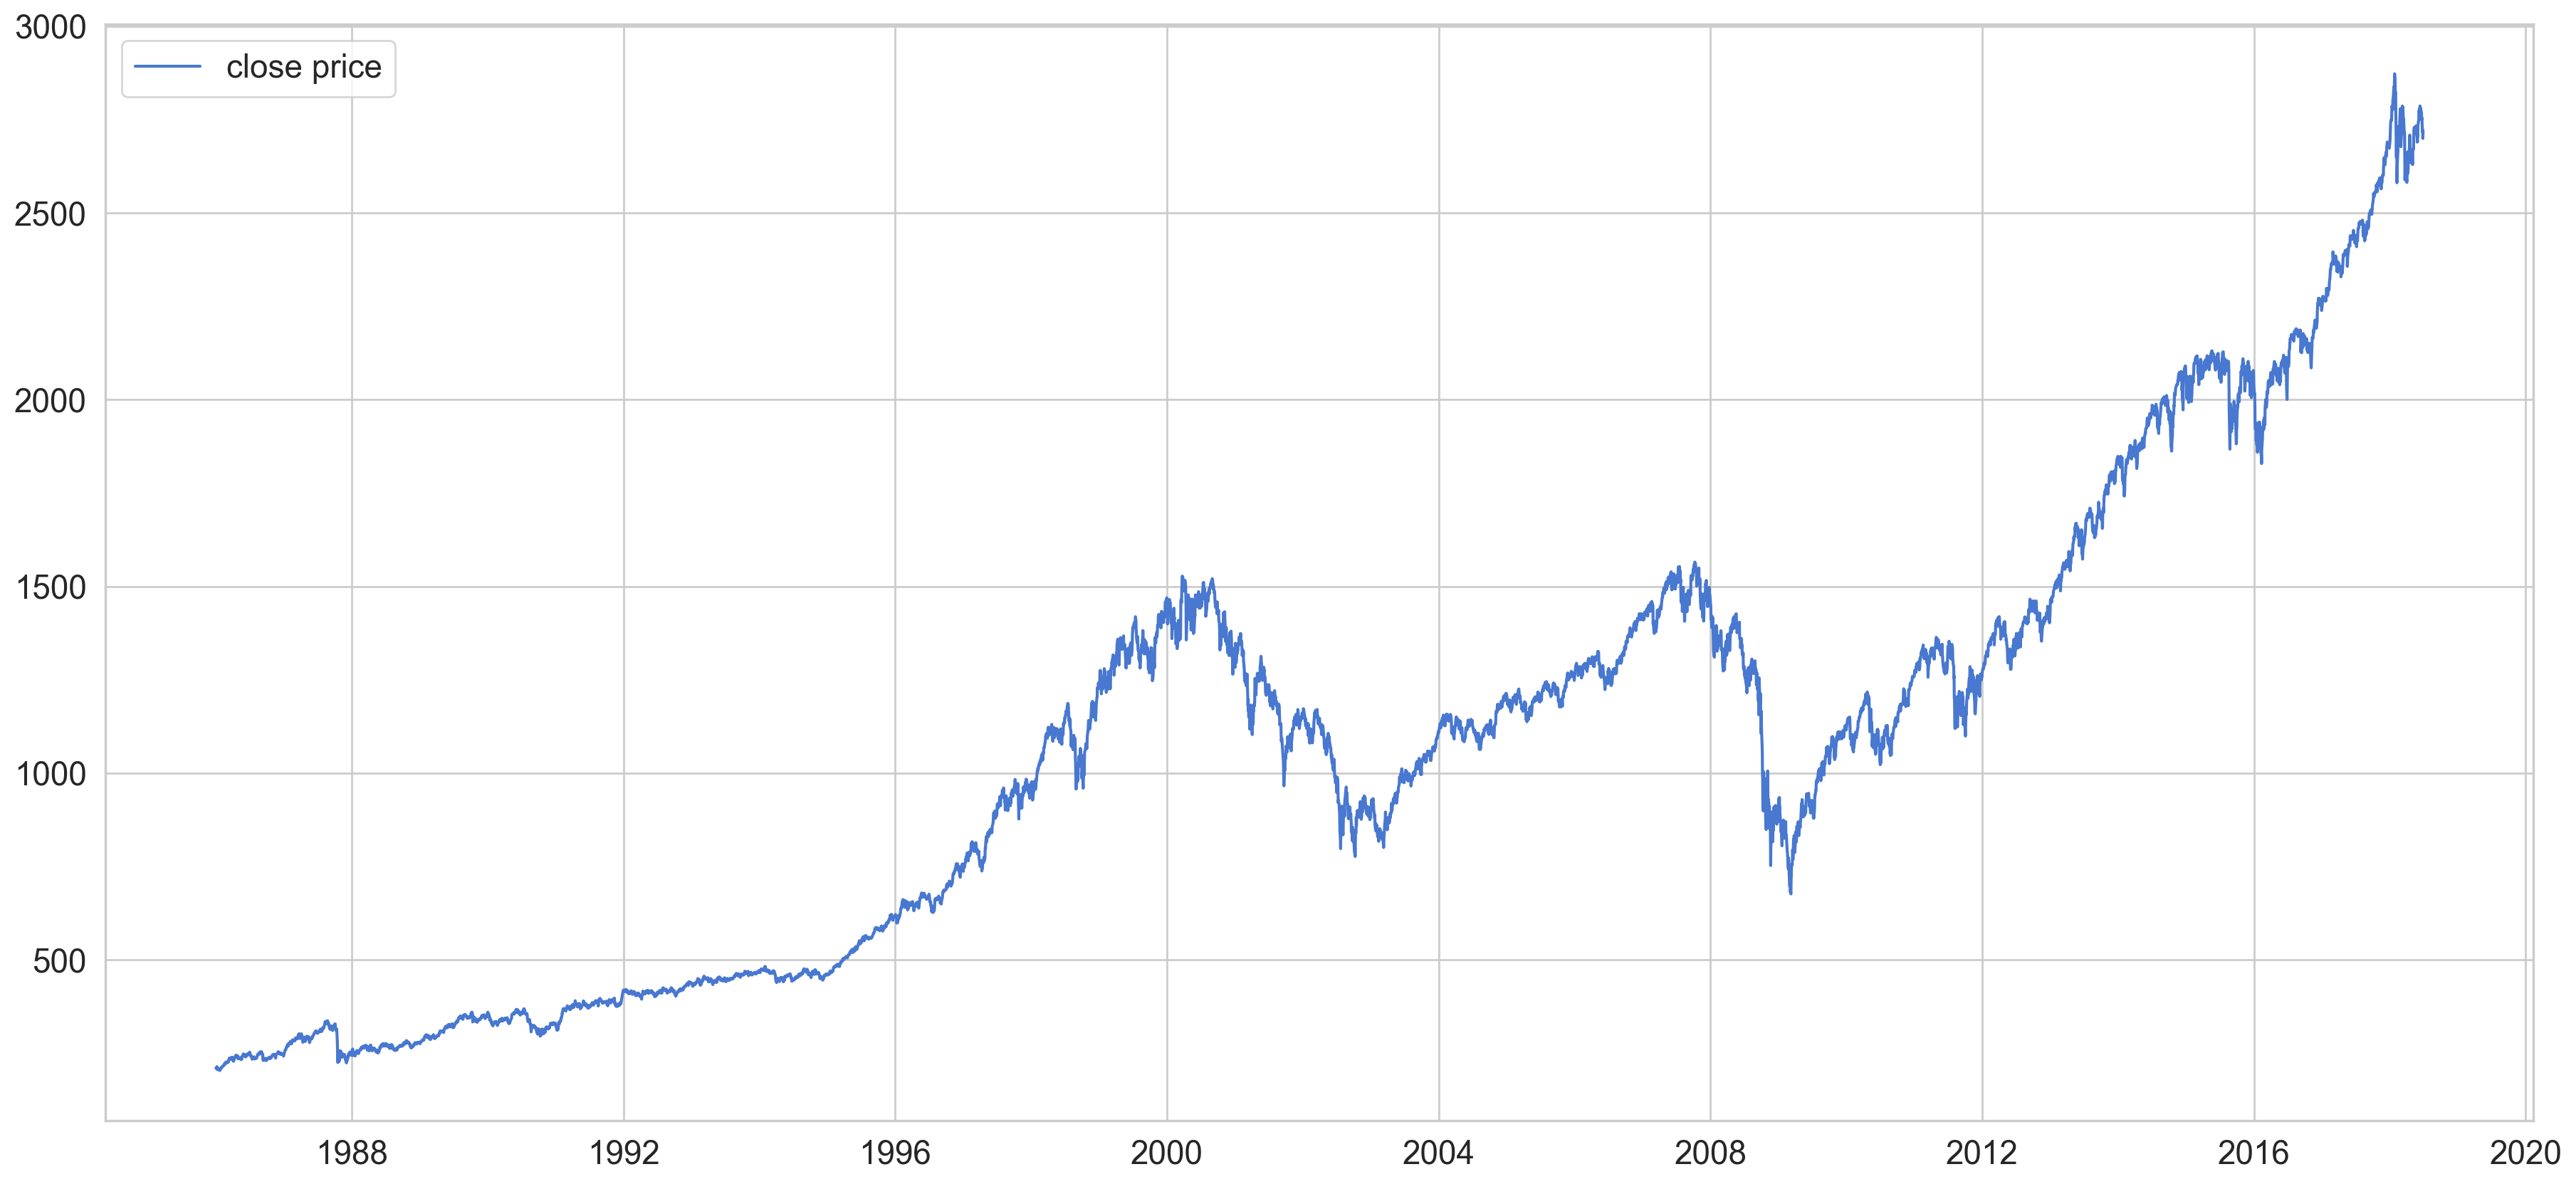

In [5]:
plt.plot(df, label='close price')
plt.legend();

In [6]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\TnAky\AppData\Local\Temp\ipykernel_22128\2699786760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
C:\Users\TnAky\AppData\Local\Temp\ipykernel_22128\2699786760.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [10]:
print(y_train.shape)

(7752,)


In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 4s 11ms/step - loss: 0.1717 - val_loss: 0.2246
Epoch 2/10
218/218 [==============================] - 2s 9ms/step - loss: 0.1073 - val_loss: 0.1767
Epoch 3/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1015 - val_loss: 0.1251
Epoch 4/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1044 - val_loss: 0.1700
Epoch 5/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1308 - val_loss: 0.2913
Epoch 6/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1141 - val_loss: 0.2589
Epoch 7/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1135 - val_loss: 0.2465
Epoch 8/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1230 - val_loss: 0.1512
Epoch 9/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1149 - val_loss: 0.1206
Epoch 10/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1204 - val_loss: 0.128

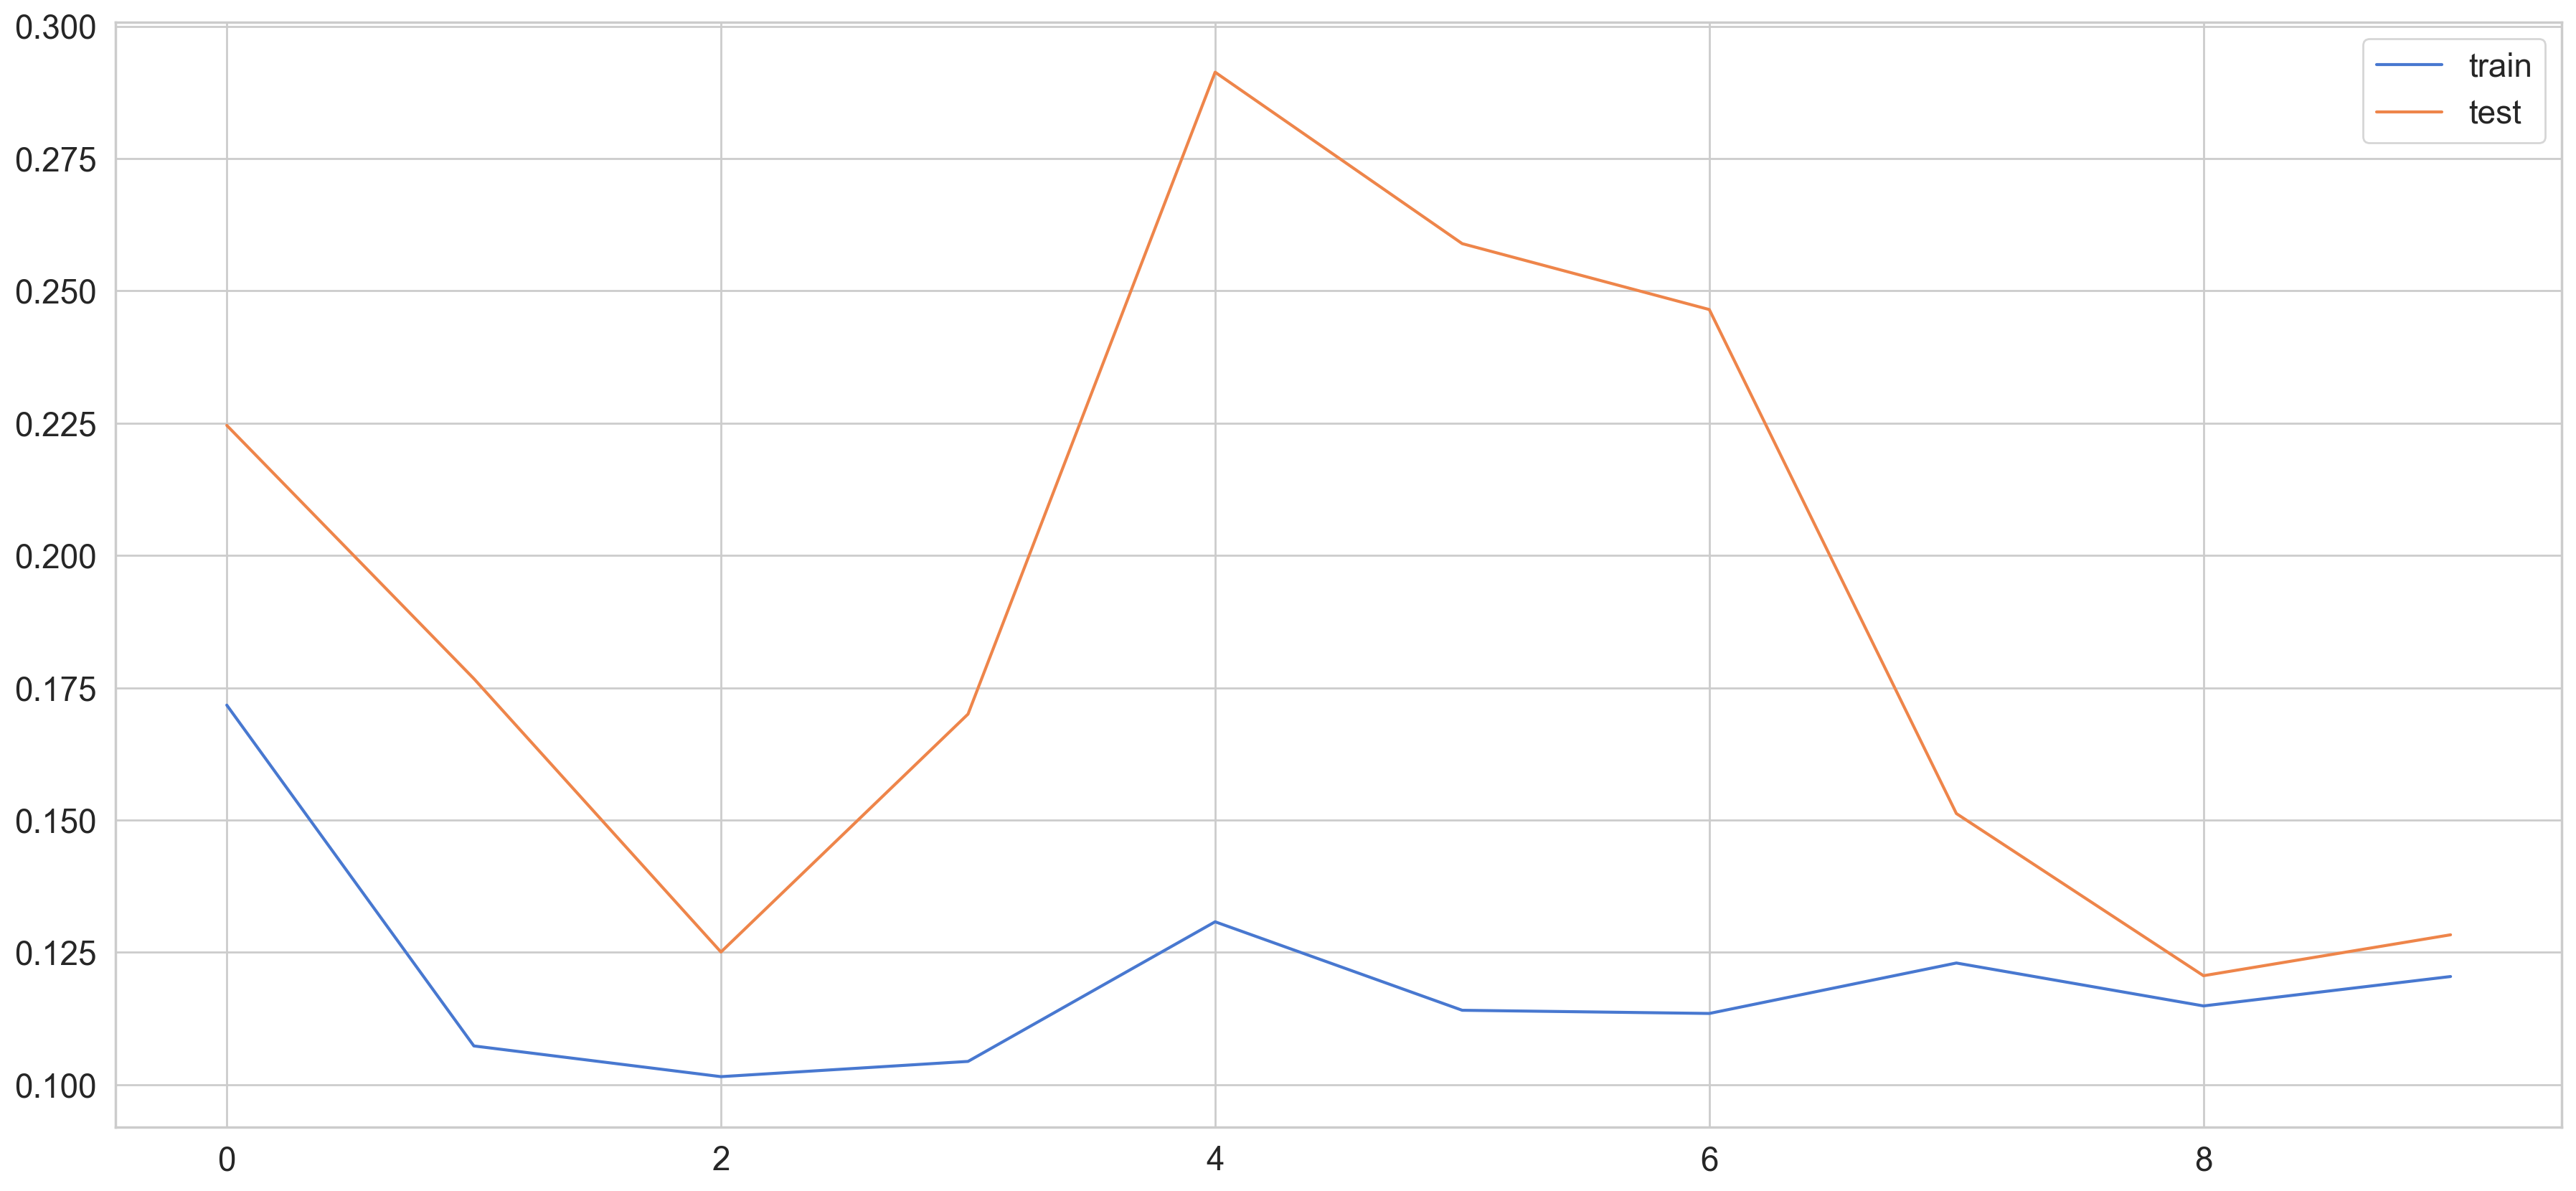

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 1s 3ms/step


C:\Users\TnAky\AppData\Local\Temp\ipykernel_22128\3686310114.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


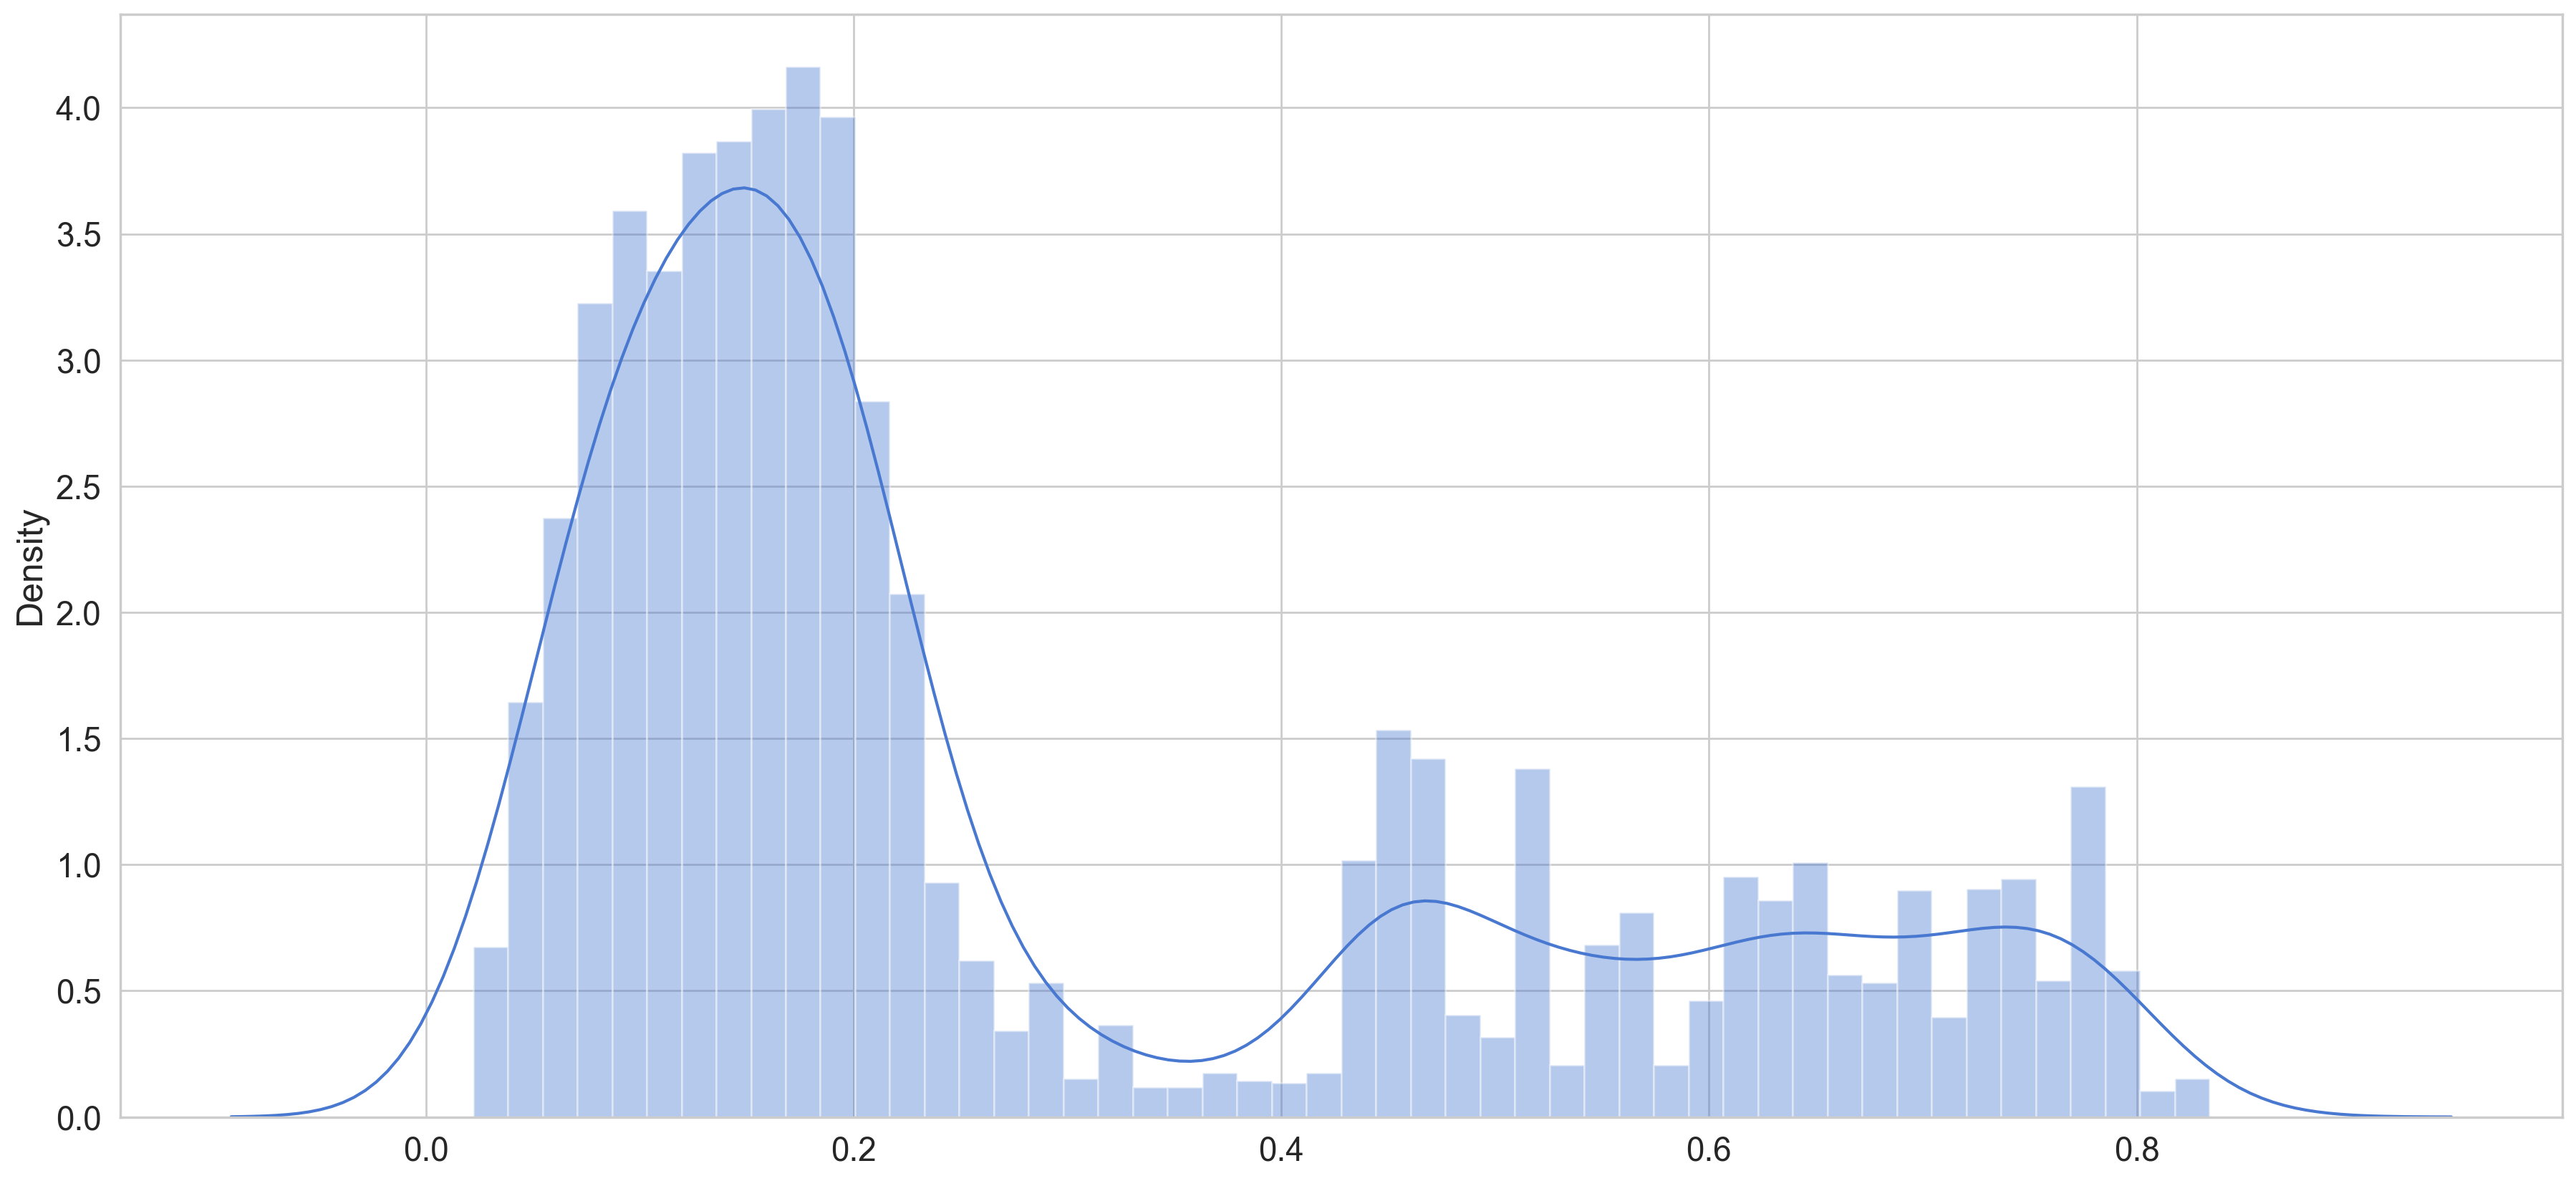

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 3ms/step


In [18]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close
test_score_df

,loss,threshold,anomaly,close
date,,,,
2016-12-27,0.195078,0.65,False,2.392816
2016-12-28,0.196551,0.65,False,2.357204
2016-12-29,0.206400,0.65,False,2.355964
2016-12-30,0.212116,0.65,False,2.336373
2017-01-03,0.221106,0.65,False,2.372061
...,...,...,...,...
2018-06-25,0.604733,0.65,False,3.234646
2018-06-26,0.619698,0.65,False,3.245897
2018-06-27,0.625601,0.65,False,3.201889


In [21]:
test_mae_loss.shape

(380, 1)

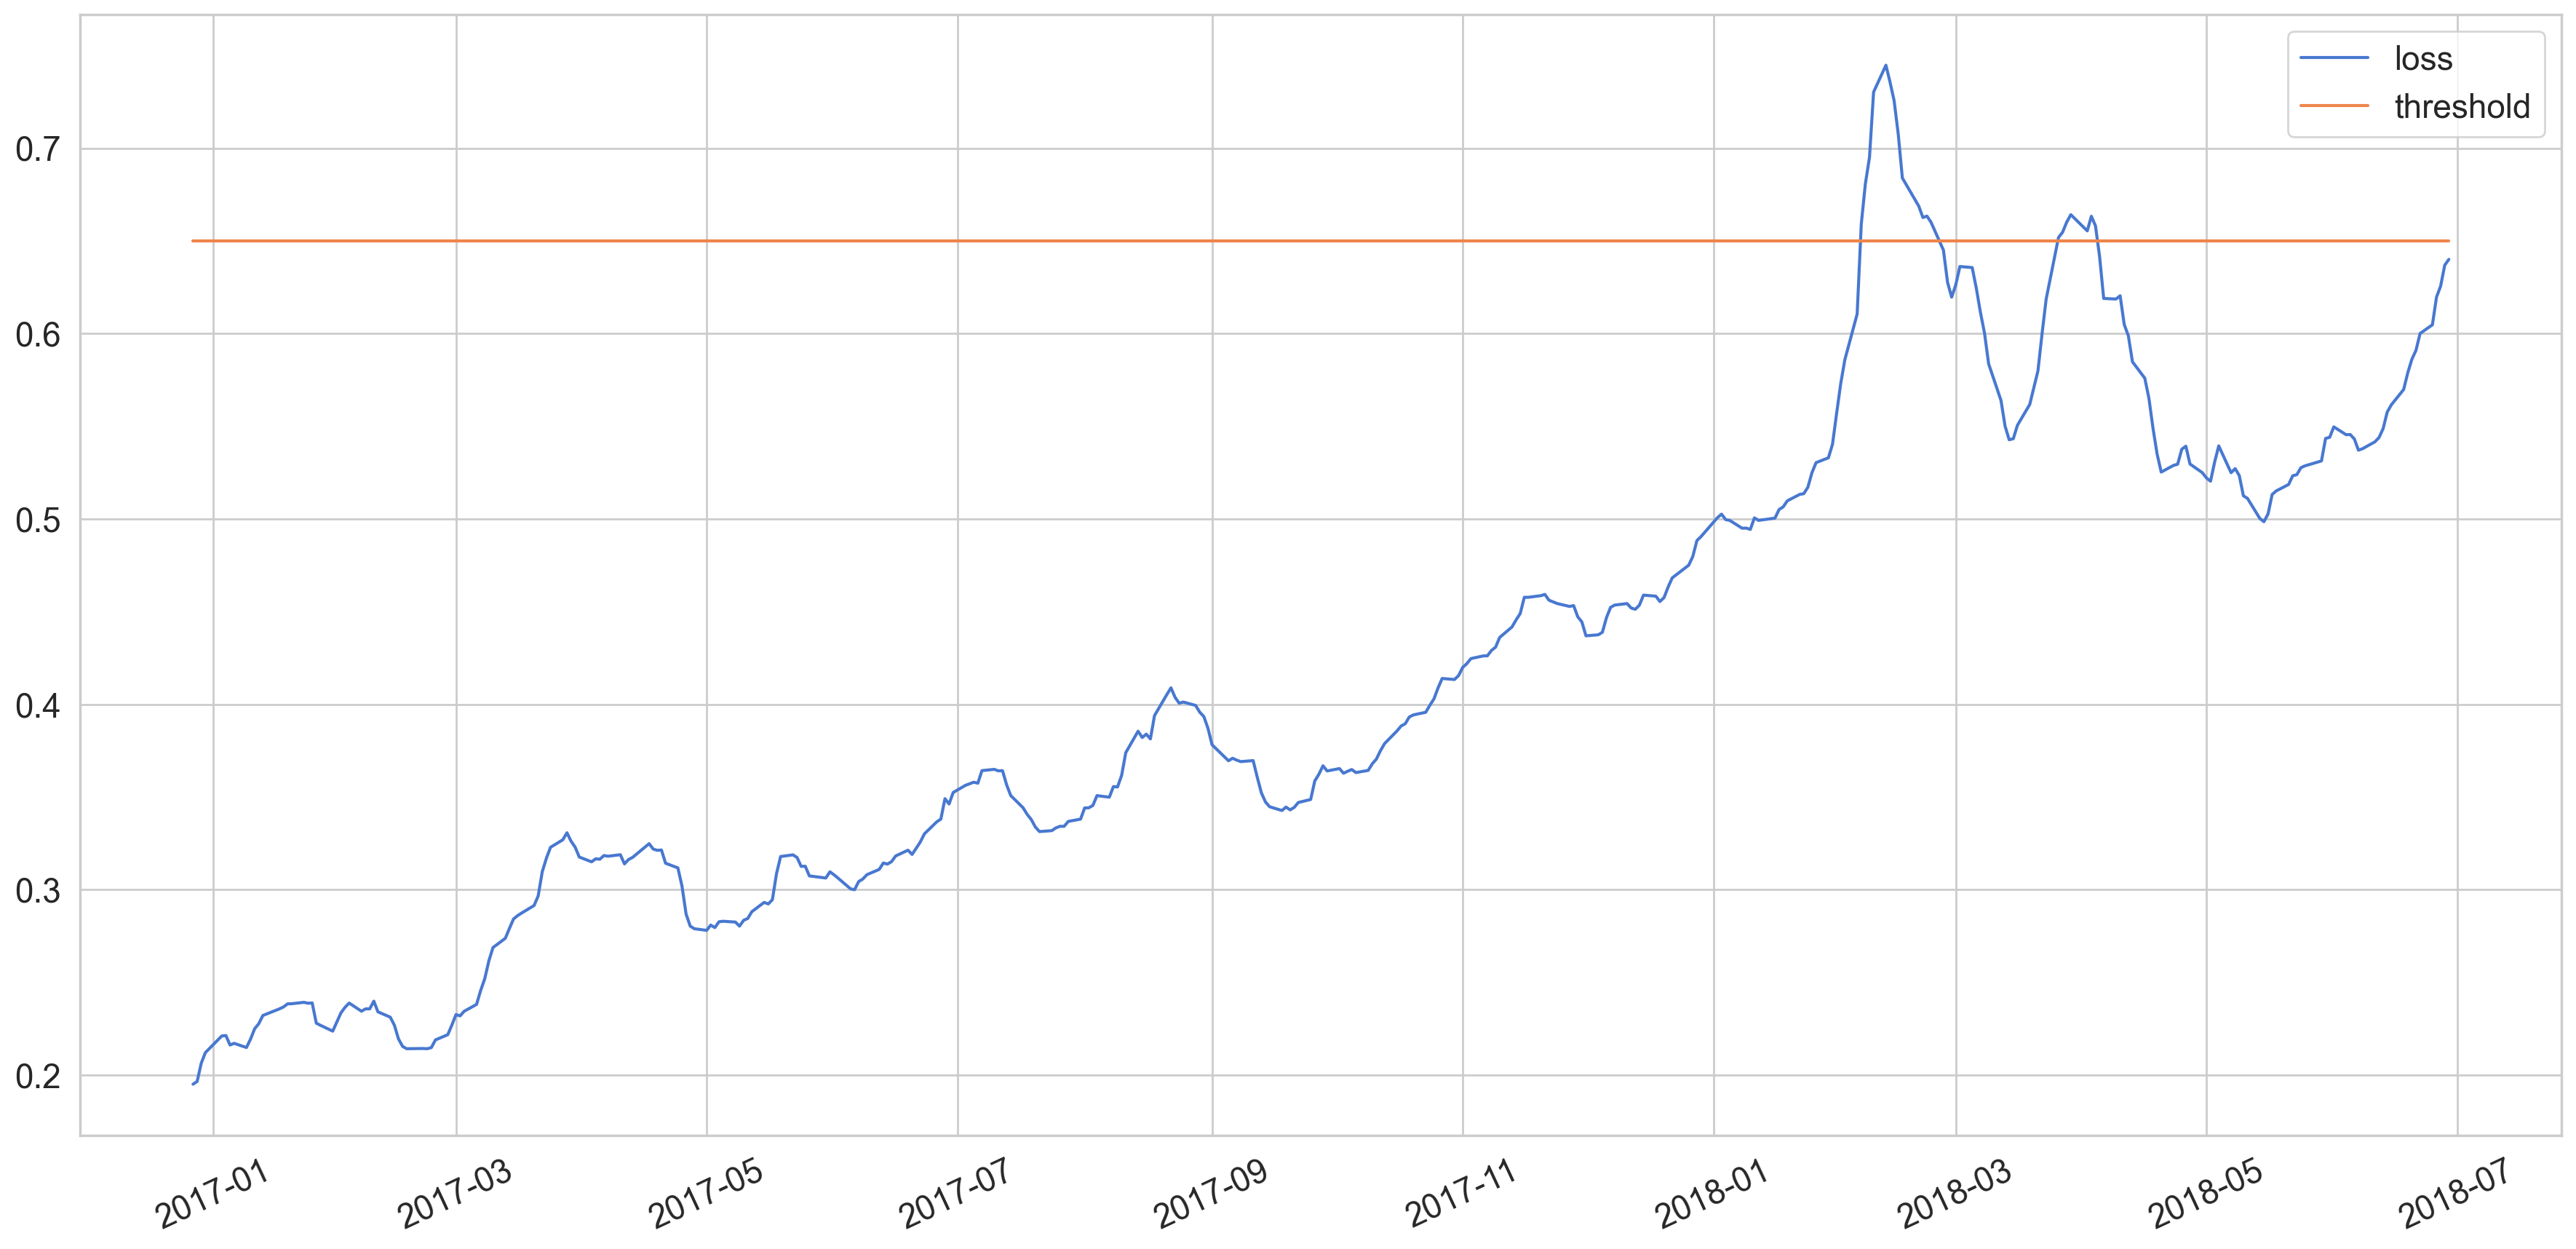

In [22]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [23]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.658943,0.65,True,3.193456
2018-02-07,0.680816,0.65,True,3.168136
2018-02-08,0.695021,0.65,True,2.979068
2018-02-09,0.730246,0.65,True,3.051476
2018-02-12,0.744747,0.65,True,3.119939


In [26]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

# sns.scatterplot(
#   anomalies.index,
#   scaler.inverse_transform(anomalies.close),
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )
# plt.xticks(rotation=25)
# plt.legend();

ValueError: Expected 2D array, got 1D array instead:
array=[2.39281599 2.35720362 2.35596395 2.33637339 2.37206089 2.39632839
 2.39304138 2.40803013 2.39285355 2.39285355 2.40491217 2.39574612
 2.40363494 2.39095648 2.39846964 2.38306767 2.39738023 2.38590388
 2.41383405 2.44820674 2.44503243 2.44129464 2.41539303 2.4115801
 2.41285734 2.41529911 2.44642237 2.43729388 2.43827059 2.44125707
 2.46605049 2.48150881 2.50433002 2.52185446 2.5437741  2.53996117
 2.54736163 2.57407091 2.56926249 2.57112199 2.57775235 2.58227903
 2.57080268 2.63150899 2.60513781 2.60739176 2.59272232 2.57972456
 2.56956301 2.57311298 2.58763216 2.58926627 2.57420239 2.6114113
 2.60412354 2.59824449 2.58926627 2.53395065 2.54227147 2.53759453
 2.53387552 2.5293864  2.56127976 2.56608818 2.57910472 2.56907466
 2.56178689 2.56426624 2.55072377 2.5592512  2.55558854 2.55863137
 2.55228275 2.53565989 2.50564483 2.54332331 2.53051338 2.52296265
 2.55615203 2.54272226 2.5905435  2.61770357 2.61552475 2.61800409
 2.60942031 2.61717765 2.62251199 2.61680199 2.61941281 2.6377637
 2.63793274 2.63331215 2.63840232 2.62865399 2.62200485 2.64345491
 2.64035574 2.55838719 2.57470953 2.60478094 2.62786511 2.63612959
 2.64734297 2.6674031  2.66881182 2.663346   2.6612611  2.69555866
 2.71248205 2.70690353 2.69418751 2.70134379 2.70256468 2.69877053
 2.69430021 2.71488626 2.71032201 2.70006655 2.70136257 2.73951063
 2.70865034 2.70598316 2.70389826 2.71103576 2.71248205 2.67549853
 2.71552487 2.67609958 2.68306804 2.69358646 2.70021682 2.6574106
 2.68639261 2.69061876 2.68705001 2.7203333  2.72893586 2.75042349
 2.75017931 2.7529404  2.77777138 2.77705763 2.77534839 2.77040849
 2.78396974 2.78528454 2.78075786 2.77452194 2.77114102 2.78250467
 2.78479618 2.77463464 2.78340625 2.79106967 2.77981872 2.77812826
 2.71086672 2.7167082  2.76276385 2.76045355 2.76702757 2.69546474
 2.68708757 2.69238435 2.73772625 2.72181714 2.71229422 2.71995764
 2.7221928  2.72606208 2.74726796 2.77367671 2.78288033 2.74775632
 2.76220036 2.76137392 2.75448059 2.80459335 2.82031464 2.8238646
 2.81869931 2.82735822 2.83419519 2.83941684 2.84240332 2.82805319
 2.83109602 2.82065273 2.82099082 2.84014937 2.8458218  2.86328989
 2.881622   2.89187746 2.89781285 2.92472874 2.91958222 2.91094209
 2.92204278 2.93068291 2.92258749 2.92679486 2.93519081 2.93842147
 2.94199022 2.94356798 2.96819235 2.94897745 2.95677235 2.93427045
 2.94037489 2.97919913 2.96372202 2.96828627 2.97598725 2.97690761
 2.99191515 2.99809472 2.99717436 3.00419916 2.98586705 2.98150942
 2.98628028 2.97506689 2.94830127 2.98778291 2.97502933 2.9812089
 3.0129332  3.00927054 3.0193006  3.01742231 3.06554409 3.06372215
 3.10412415 3.09405652 3.08883487 3.07029616 3.06973267 3.08421428
 3.11148704 3.12743372 3.13517227 3.13280563 3.11244497 3.15714826
 3.18410171 3.16777937 3.16360957 3.17360207 3.17129178 3.16595743
 3.16993941 3.17918059 3.15301602 3.19471404 3.22711453 3.24764424
 3.28363226 3.29219726 3.29892153 3.29317397 3.3294813  3.36456774
 3.34612294 3.39522143 3.38671278 3.40975939 3.4523402  3.46391047
 3.46092399 3.46413586 3.52728395 3.49095783 3.43254303 3.43513507
 3.4316978  3.31928219 3.10667862 3.19345559 3.16813625 2.97906765
 3.0514757  3.11993935 3.13297467 3.20001082 3.2611867  3.26310256
 3.23312506 3.2050822  3.2100221  3.29142716 3.3520959  3.28575473
 3.22856082 3.16064187 3.18614904 3.24191545 3.25540157 3.25292223
 3.27578101 3.36518758 3.35851965 3.32525515 3.29552183 3.29148351
 3.3002739  3.22685157 3.2344023  3.22499207 3.0968176  2.99270403
 3.12472898 3.03845916 3.02414659 3.09152083 2.98072054 3.04189642
 3.09869589 3.13278684 3.0231511  3.03947343 3.12157346 3.09400017
 3.13494688 3.12050283 3.16096118 3.21458634 3.21881249 3.18968023
 3.14649836 3.1467801  3.07966882 3.08875974 3.14048783 3.14606635
 3.10500695 3.1176854  3.08175372 3.07059669 3.13387625 3.1511753
 3.14984171 3.19843306 3.24591621 3.25465025 3.25917693 3.22409049
 3.24477045 3.24039404 3.22694549 3.2645864  3.24848947 3.26511233
 3.25472539 3.24264799 3.18353822 3.2476818  3.21248266 3.26761045
 3.29061949 3.29424459 3.33847831 3.33475929 3.35102528 3.3566038
 3.3657135  3.3446391  3.35752416 3.3522086  3.34110791 3.3201462
 3.32903051 3.29604775 3.30566459 3.23464647 3.24589743 3.20188911
 3.23321897 3.23708825].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.